# 영화 장르 간 편향성 분석 (WEAT)

## STEP 1. 데이터 준비 및 형태소 분석

- 전체 시놉시스 데이터를 읽어 형태소 분석기로 명사를 추출합니다.

In [1]:
import os
from konlpy.tag import Okt

data_dir = "data"
file_name = os.path.join(data_dir, "synopsis.txt")

okt = Okt()
tokenized = []
with open(file_name, 'r') as file:
    print(f"{file_name} 파일을 읽고 있습니다.")
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = [w[0] for w in words if w[1] in ["Noun"]]
        tokenized.append(res)

data/synopsis.txt 파일을 읽고 있습니다.


## STEP 2. Word2Vec 임베딩 모델 생성

In [2]:
from gensim.models import Word2Vec

# Skip-gram 방식으로 Word2Vec 모델을 학습합니다.
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=1)

print("Word2Vec 모델 학습 완료")
model.wv.most_similar(positive=['영화'])

Word2Vec 모델 학습 완료


[('영화로', 0.7715044617652893),
 ('작품', 0.7359510064125061),
 ('공포영화', 0.7239106893539429),
 ('픽션', 0.7135831713676453),
 ('주제', 0.7130668759346008),
 ('코미디', 0.7129327654838562),
 ('무성영화', 0.7070550322532654),
 ('형식', 0.7066085934638977),
 ('설정', 0.7029204368591309),
 ('극영화', 0.6966939568519592)]

## STEP 3. Target 및 Attribute 단어 셋 구축

기존 TF-IDF 방식은 장르에 상관없이 자주 등장하는 일반적인 단어(예: 영화, 사람, 자신)가 여러 장르의 대표 단어로 중복 선정되는 문제가 있었습니다. 이로 인해 장르 간의 미묘한 편향성을 측정하기 어려웠습니다.

이를 해결하기 위해, **한 장르에서는 TF-IDF 점수가 높지만 다른 모든 장르의 TF-IDF 점수 평균보다 월등히 높은 단어**를 해당 장르의 대표 단어로 선정하는 방식을 사용합니다. 이 방법은 각 장르의 고유한 특징을 더 잘 반영하는 단어들을 추출하여 WEAT 점수의 신뢰도를 높입니다.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.path.join(data_dir, file_name), 'r') as fread:
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))
    return ' '.join(result)

# Target 단어셋 (예술영화, 일반영화) 구축
art_corpus = read_token(art_txt)
gen_corpus = read_token(gen_txt)

target_vectorizer = TfidfVectorizer()
target_X = target_vectorizer.fit_transform([art_corpus, gen_corpus])

target_art_words, target_gen_words = [], []
art_scores = target_X[0].toarray().flatten()
gen_scores = target_X[1].toarray().flatten()
feature_names = target_vectorizer.get_feature_names_out()

diff_scores = art_scores - gen_scores
sorted_indices = np.argsort(diff_scores)

# gen_scores가 높은 단어 (일반영화) 중 15개 추출
i = 0
while len(target_gen_words) < 15 and i < len(sorted_indices):
    idx = sorted_indices[i]
    if feature_names[idx] in model.wv: target_gen_words.append(feature_names[idx])
    i += 1

# art_scores가 높은 단어 (예술영화) 중 15개 추출
i = -1
while len(target_art_words) < 15 and abs(i) <= len(sorted_indices):
    idx = sorted_indices[i]
    if feature_names[idx] in model.wv: target_art_words.append(feature_names[idx])
    i -= 1

print("Target Art Words:", target_art_words)
print("Target Gen Words:", target_gen_words)

# Attribute 단어셋 (21개 장르) 구축
genre_corpus = [read_token(file) for file in genre_txt]
attr_vectorizer = TfidfVectorizer()
attr_X = attr_vectorizer.fit_transform(genre_corpus)
attr_feature_names = attr_vectorizer.get_feature_names_out()

attributes = []
for i in range(len(genre_name)):
    scores = attr_X[i].toarray().flatten()
    other_scores_mean = np.mean(np.delete(attr_X.toarray(), i, axis=0), axis=0)
    
    # 자신의 TF-IDF가 다른 장르 평균의 1.5배 이상인 단어들 중 상위 15개 추출
    unique_word_indices = np.where(scores > other_scores_mean * 1.5)[0]
    sorted_unique_indices = sorted(unique_word_indices, key=lambda idx: scores[idx], reverse=True)
    
    attr = []
    for idx in sorted_unique_indices:
        word = attr_feature_names[idx]
        if word in model.wv:
            attr.append(word)
        if len(attr) == 15: break
    attributes.append(attr)

for i, attr in enumerate(attributes):
    print(f"{genre_name[i]}: {attr}")

Target Art Words: ['사랑', '시작', '과연', '세상', '마을', '마음', '인생', '위해', '가족', '음악', '아빠', '사람', '모든', '서로', '파리']
Target Gen Words: ['영화제', '국제', '서울', '애니메이션', '작품', '단편', '남편', '연출', '의도', '부문', '여성', '관계', '섹스', '생각', '부천']
SF: ['지구', '인류', '인간', '미래', '우주', '로봇', '세계', '모든', '박사', '우주선', '외계', '존재', '세상', '행성', '정체']
가족: ['엄마', '아빠', '가족', '영화제', '친구', '아주르', '아버지', '아들', '국제', '마을', '낙타', '할머니', '씨제이', '동구', '아이']
공연: ['오페라', '사랑', '토스카', '실황', '올레', '카바', '공연', '오텔로', '리골레토', '백작', '프레', '베르디', '비바', '카르피', '왕자']
공포(호러): ['시작', '사람', '친구', '사건', '공포', '발견', '죽음', '마을', '가족', '악령', '좀비', '사실', '소녀', '하나', '살인']
기타: ['영화제', '국제', '서울', '단편', '영화', '이야기', '뉴미디어', '페스티벌', '독립', '작품', '통해', '아시아나', '우리', '연출', '이미지']
다큐멘터리: ['영화제', '영화', '다큐', '국제', '다큐멘터리', '이야기', '대한', '감독', '서울', '우리', '세계', '통해', '여성', '한국', '작품']
드라마: ['영화제', '사랑', '영화', '국제', '남자', '이야기', '엄마', '여자', '아버지', '가족', '단편', '서울', '대한', '아들', '마음']
멜로로맨스: ['그녀', '사랑', '남편', '남자', '여자', '친구', '섹스', '마음', '결혼', '서로', '아내', '

## STEP 4. WEAT Score 계산 및 시각화

In [6]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X-mean_Y)/std_dev

X = np.array([model.wv[word] for word in target_art_words])
Y = np.array([model.wv[word] for word in target_gen_words])

matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

for i in range(len(genre_name)):
    for j in range(i + 1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        score = weat_score(X, Y, A, B)
        matrix[i][j] = score
        matrix[j][i] = -score # 대칭 위치에는 부호 반대 값을 할당

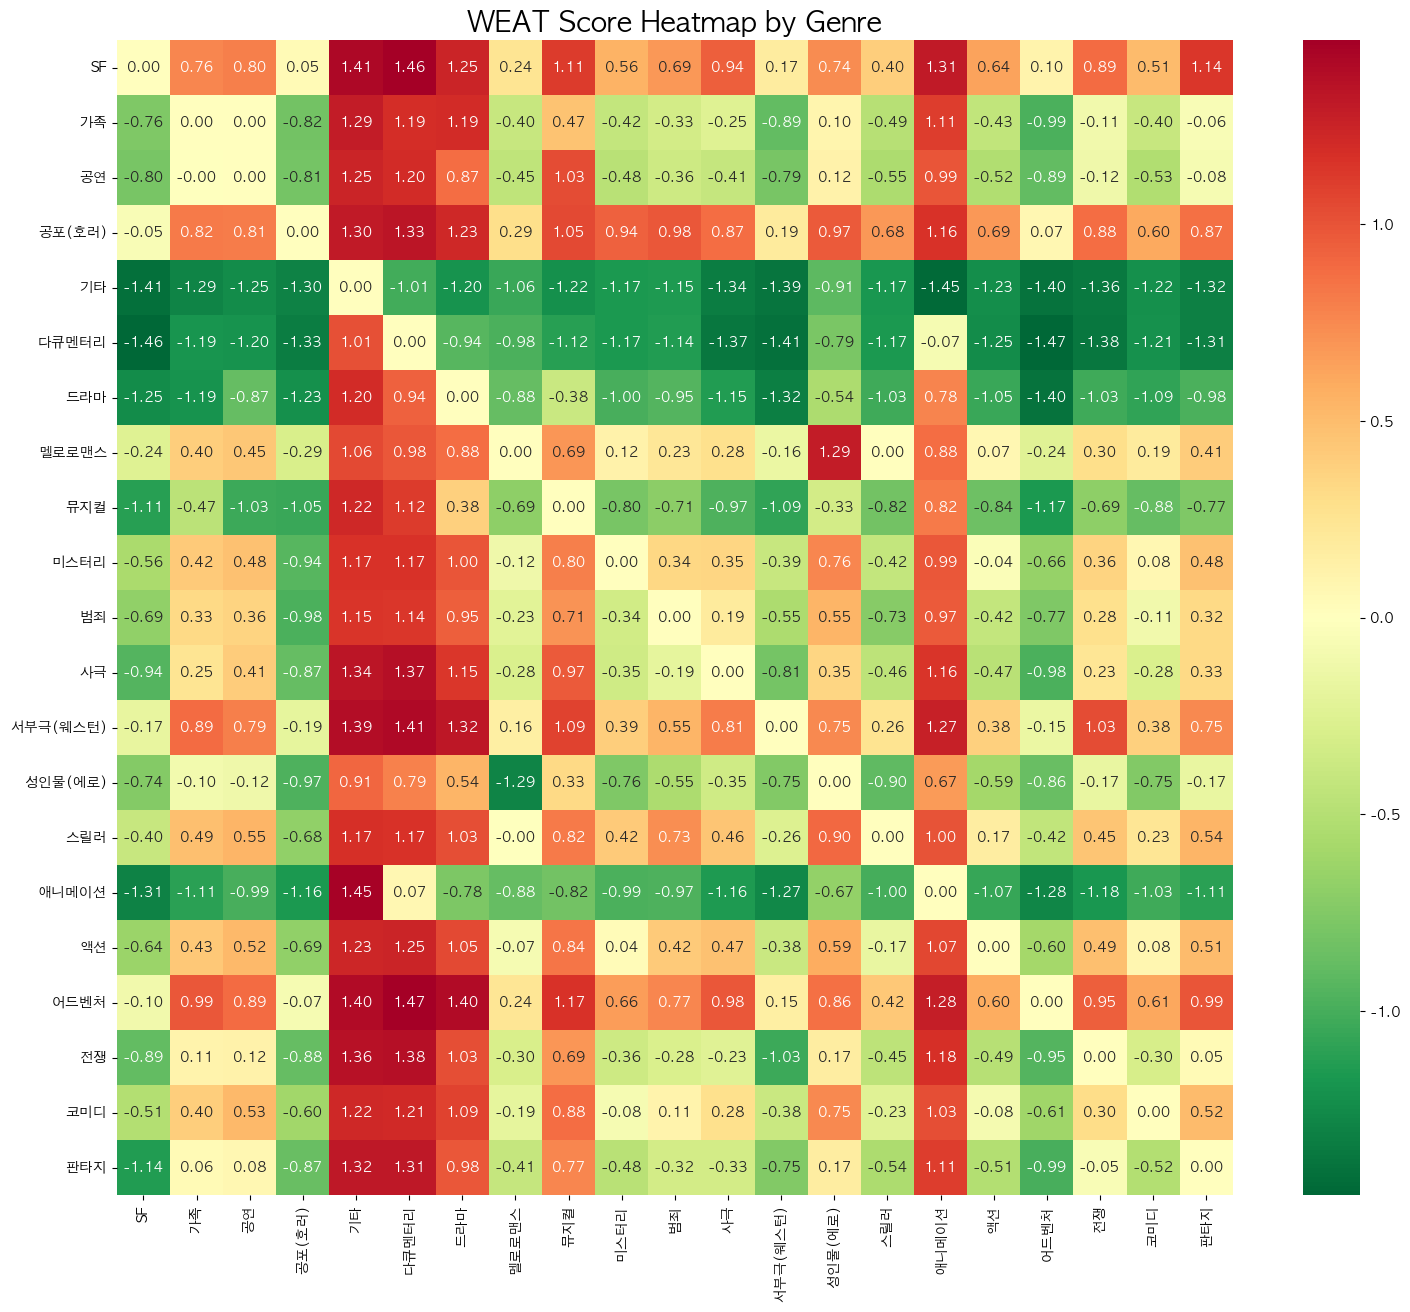

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 지원 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', fmt='.2f', ax=ax)
ax.set_title('WEAT Score Heatmap by Genre', fontsize=20)
plt.show()

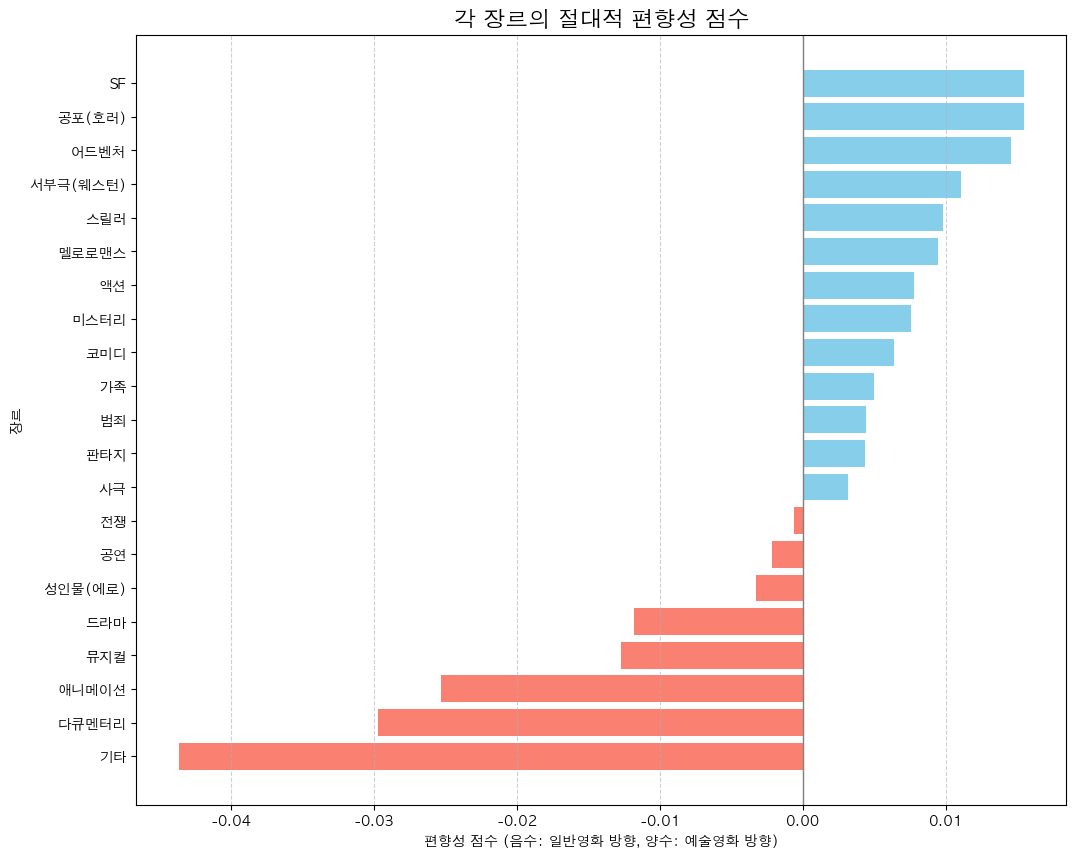

In [8]:
# 각 장르의 '절대 편향성'을 계산하는 함수
def absolute_weat_score(A, X, Y):
    # A에 속한 각 단어 a에 대해 s(a, X, Y)를 계산
    # s(a, X, Y)는 단어 a가 X에 가까운지 Y에 가까운지를 나타냄
    s_A = np.array([s(a, X, Y) for a in A])
    # 그 값들의 평균을 반환
    return np.mean(s_A)

# 각 장르별 절대 편향성 점수 계산
art_embeddings = np.array([model.wv[word] for word in target_art_words])
gen_embeddings = np.array([model.wv[word] for word in target_gen_words])
absolute_scores = {}

for i in range(len(genre_name)):
    # 장르별 대표 단어들의 임베딩 벡터
    A_embeddings = np.array([model.wv[word] for word in attributes[i]])
    # 절대 편향성 점수 계산
    score = absolute_weat_score(A_embeddings, art_embeddings, gen_embeddings)
    absolute_scores[genre_name[i]] = score

# 점수를 기준으로 정렬
sorted_scores = sorted(absolute_scores.items(), key=lambda item: item[1])

# 시각화 (막대 그래프)
genres = [item[0] for item in sorted_scores]
scores = [item[1] for item in sorted_scores]

plt.figure(figsize=(12, 10))
plt.barh(genres, scores, color=['skyblue' if s > 0 else 'salmon' for s in scores])
plt.title('각 장르의 절대적 편향성 점수', fontsize=16)
plt.xlabel('편향성 점수 (음수: 일반영화 방향, 양수: 예술영화 방향)')
plt.ylabel('장르')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.axvline(0, color='grey', linewidth=1) # 0점 기준선
plt.show()

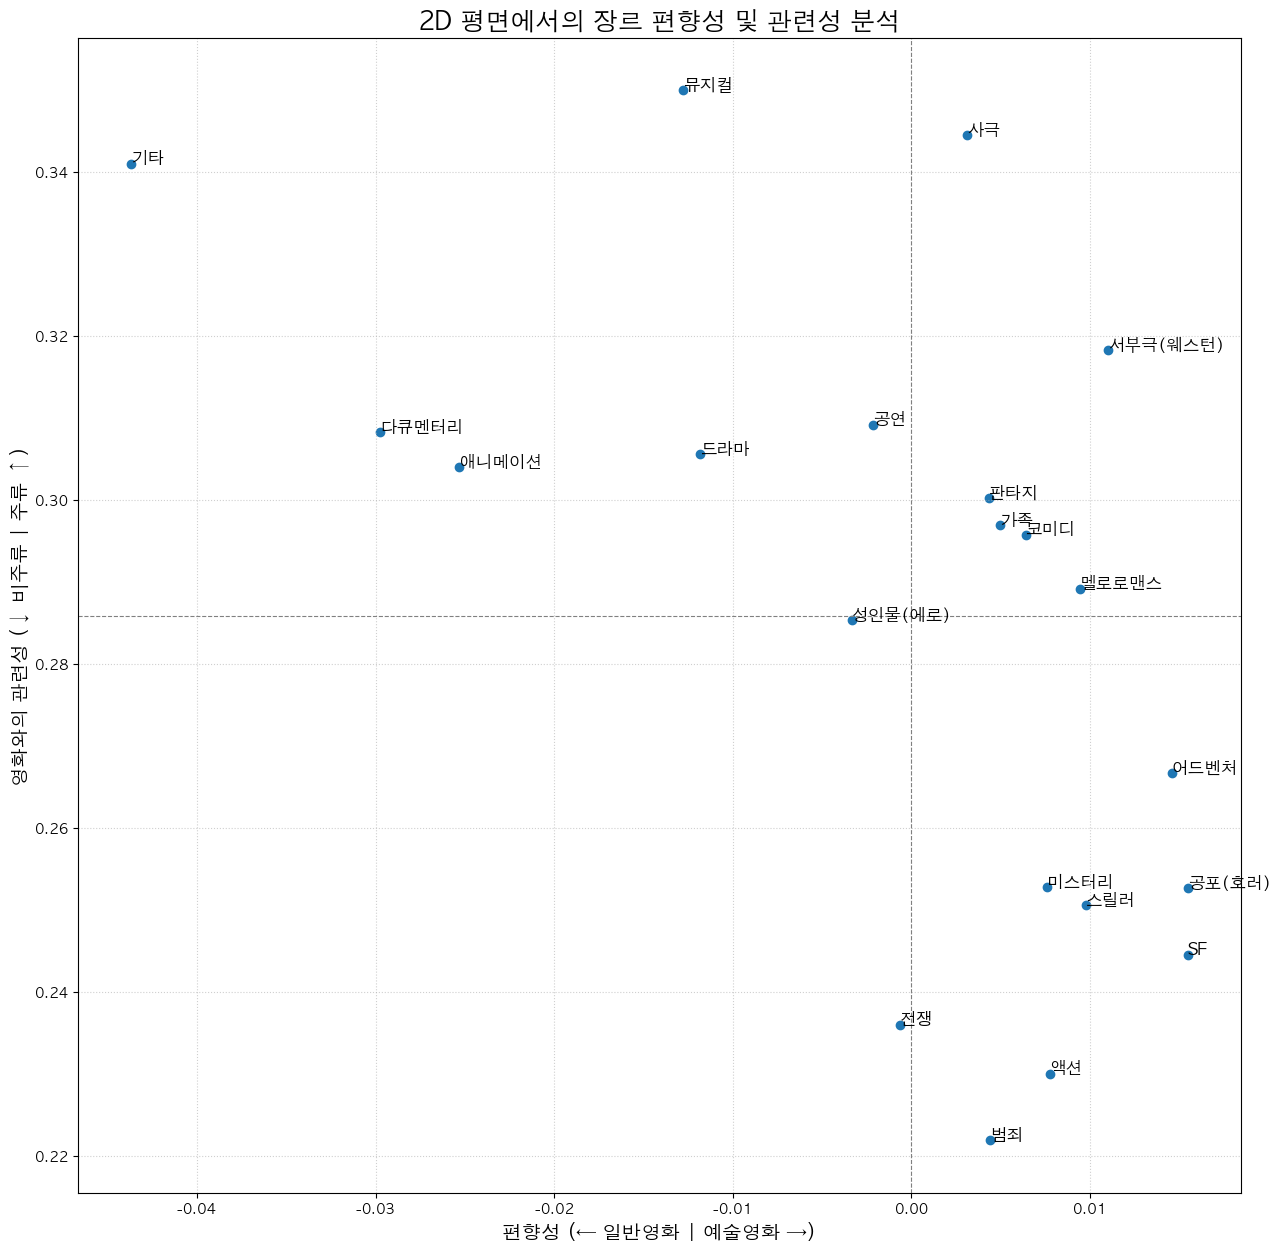

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Y축 점수(관련성/강도)를 계산하는 함수
def intensity_score(A, X, Y):
    # A에 속한 각 단어 a에 대해 (s(a, X) + s(a, Y)) / 2 를 계산
    # 즉, 예술/상업 양쪽과의 평균 유사도를 계산
    mean_X = np.mean([cosine_similarity([a], [x])[0][0] for a in A for x in X])
    mean_Y = np.mean([cosine_similarity([a], [y])[0][0] for a in A for y in Y])
    return (mean_X + mean_Y) / 2

# 각 장르별 X축, Y축 점수 계산
bias_scores = {} # X축
intensity_scores = {} # Y축

art_embeddings = np.array([model.wv[word] for word in target_art_words])
gen_embeddings = np.array([model.wv[word] for word in target_gen_words])

for i in range(len(genre_name)):
    A_embeddings = np.array([model.wv[word] for word in attributes[i]])

    # X축 점수 (절대 편향성)
    bias = absolute_weat_score(A_embeddings, art_embeddings, gen_embeddings)
    bias_scores[genre_name[i]] = bias

    # Y축 점수 (영화 개념과의 관련성)
    intensity = intensity_score(A_embeddings, art_embeddings, gen_embeddings)
    intensity_scores[genre_name[i]] = intensity

# 2D 평면 시각화
plt.figure(figsize=(15, 15))

# 각 장르의 위치에 점 찍기
plt.scatter(list(bias_scores.values()), list(intensity_scores.values()))

# 각 점에 장르 이름 달기
for genre, bias in bias_scores.items():
    intensity = intensity_scores[genre]
    plt.text(bias, intensity, genre, fontsize=12)

# 축과 제목 설정
plt.title('2D 평면에서의 장르 편향성 및 관련성 분석', fontsize=18)
plt.xlabel('편향성 (← 일반영화 | 예술영화 →)', fontsize=14)
plt.ylabel('영화와의 관련성 (↓ 비주류 | 주류 ↑)', fontsize=14)

# 기준선 추가
plt.axhline(np.mean(list(intensity_scores.values())), color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

사용된 예술영화 대표 단어: ['미학', '철학', '독립', '예술', '미장센', '비평가', '상징']
사용된 일반영화 대표 단어: ['블록버스터', '흥행', '상업', '대중', '오락', '슈퍼히어로', '캐스팅', '개봉']
기존 예술영화 대표 단어: ['사랑', '시작', '과연', '세상', '마을', '마음', '인생', '위해', '가족', '음악', '아빠', '사람', '모든', '서로', '파리']
기존 일반영화 대표 단어: ['영화제', '국제', '서울', '애니메이션', '작품', '단편', '남편', '연출', '의도', '부문', '여성', '관계', '섹스', '생각', '부천']


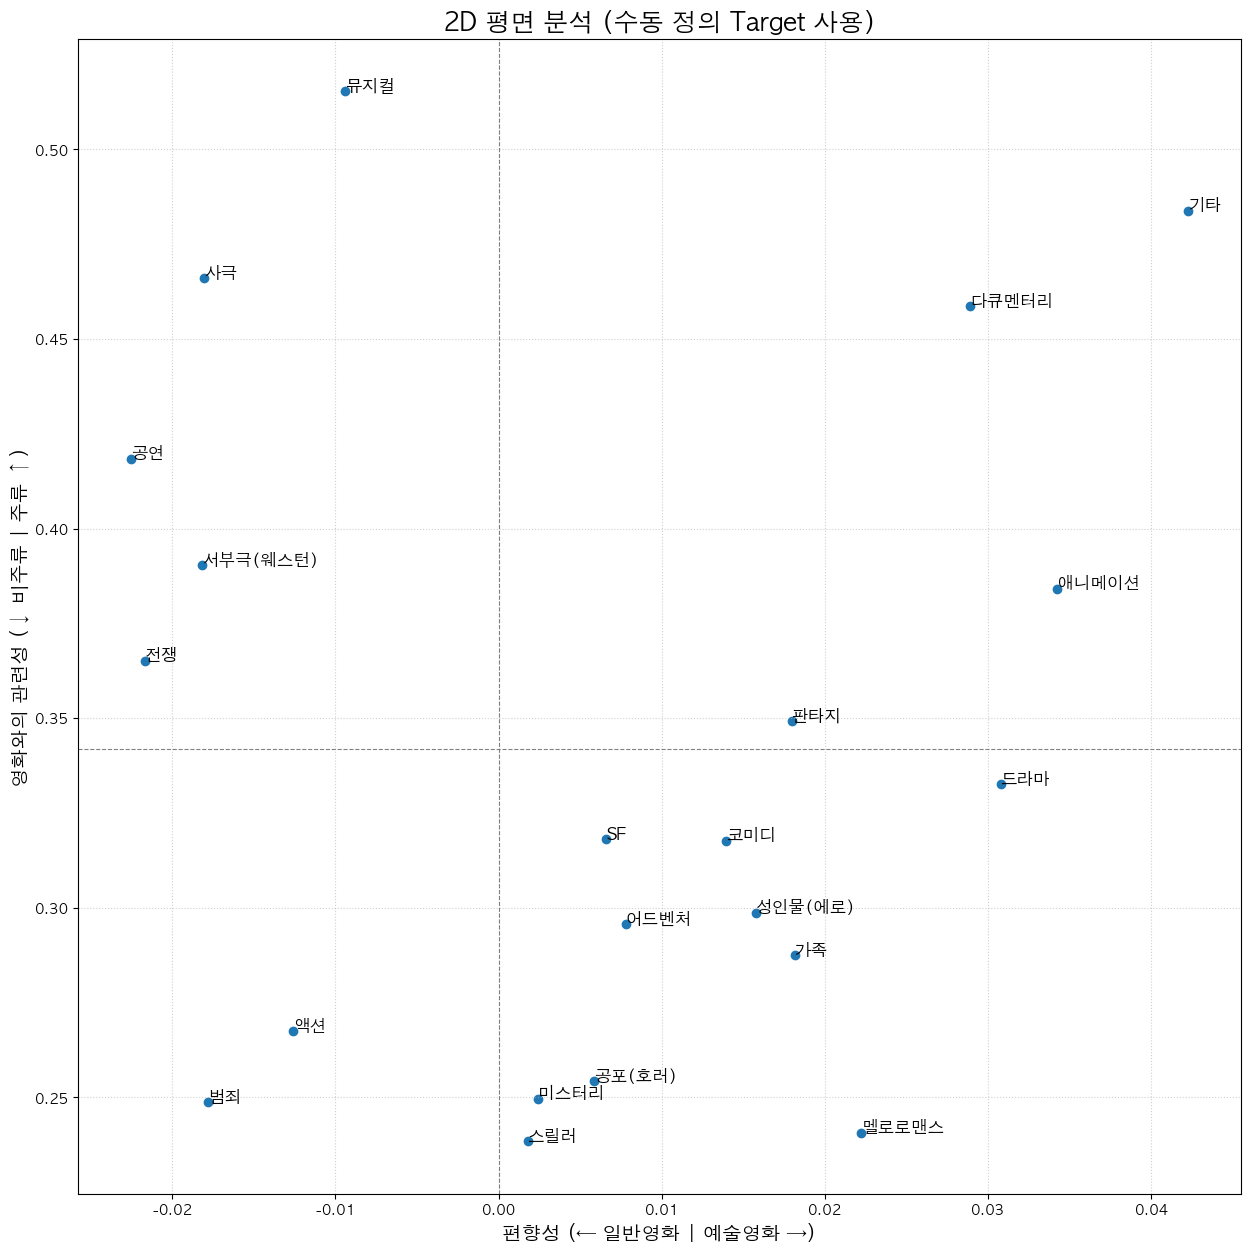

In [12]:
# STEP 5: 수동으로 정의된 Target 단어셋으로 편향성 재분석 (테스트용)

# 1. '예술'과 '상업'을 더 명확하게 대표하는 단어들을 직접 정의합니다.
manual_art_words = ['작품성', '미학', '철학', '독립', '예술', '감독주의', '미장센', '비평가', '상징']
manual_gen_words = ['블록버스터', '흥행', '상업', '대중', '오락', '슈퍼히어로', 'CG', '캐스팅', '개봉']

# 2. 우리가 학습한 Word2Vec 모델에 존재하는 단어들만 필터링합니다.
filtered_art_words = [word for word in manual_art_words if word in model.wv]
filtered_gen_words = [word for word in manual_gen_words if word in model.wv]

print("사용된 예술영화 대표 단어:", filtered_art_words)
print("사용된 일반영화 대표 단어:", filtered_gen_words)

print("================================================")

print("기존 예술영화 대표 단어:", target_art_words)
print("기존 일반영화 대표 단어:", target_gen_words)


# 3. 새로운 Target 임베딩을 준비합니다.
manual_art_embeddings = np.array([model.wv[word] for word in filtered_art_words])
manual_gen_embeddings = np.array([model.wv[word] for word in filtered_gen_words])

# 4. 새로운 점수를 계산합니다. (기존 변수와 겹치지 않도록 새 변수 사용)
manual_bias_scores = {}
manual_intensity_scores = {}

for i in range(len(genre_name)):
    # 장르별 대표 단어들의 임베딩 벡터는 기존 것을 그대로 사용
    A_embeddings = np.array([model.wv[word] for word in attributes[i]])

    # 새로운 Target 단어셋 기준으로 점수 재계산
    bias = absolute_weat_score(A_embeddings, manual_art_embeddings, manual_gen_embeddings)
    manual_bias_scores[genre_name[i]] = bias

    intensity = intensity_score(A_embeddings, manual_art_embeddings, manual_gen_embeddings)
    manual_intensity_scores[genre_name[i]] = intensity

# 5. 새로운 2D 평면 그래프를 그립니다.
sorted_manual_scores = sorted(manual_bias_scores.items(), key=lambda item: item[1])
genres_sorted = [item[0] for item in sorted_manual_scores]
bias_sorted = [item[1] for item in sorted_manual_scores]
intensity_sorted = [manual_intensity_scores[genre] for genre in genres_sorted]


plt.figure(figsize=(15, 15))
plt.scatter(list(manual_bias_scores.values()), list(manual_intensity_scores.values()))

for genre, bias in manual_bias_scores.items():
    intensity = manual_intensity_scores[genre]
    plt.text(bias, intensity, genre, fontsize=12)

plt.title('2D 평면 분석 (수동 정의 Target 사용)', fontsize=18)
plt.xlabel('편향성 (← 일반영화 | 예술영화 →)', fontsize=14)
plt.ylabel('영화와의 관련성 (↓ 비주류 | 주류 ↑)', fontsize=14)
plt.axhline(np.mean(list(manual_intensity_scores.values())), color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

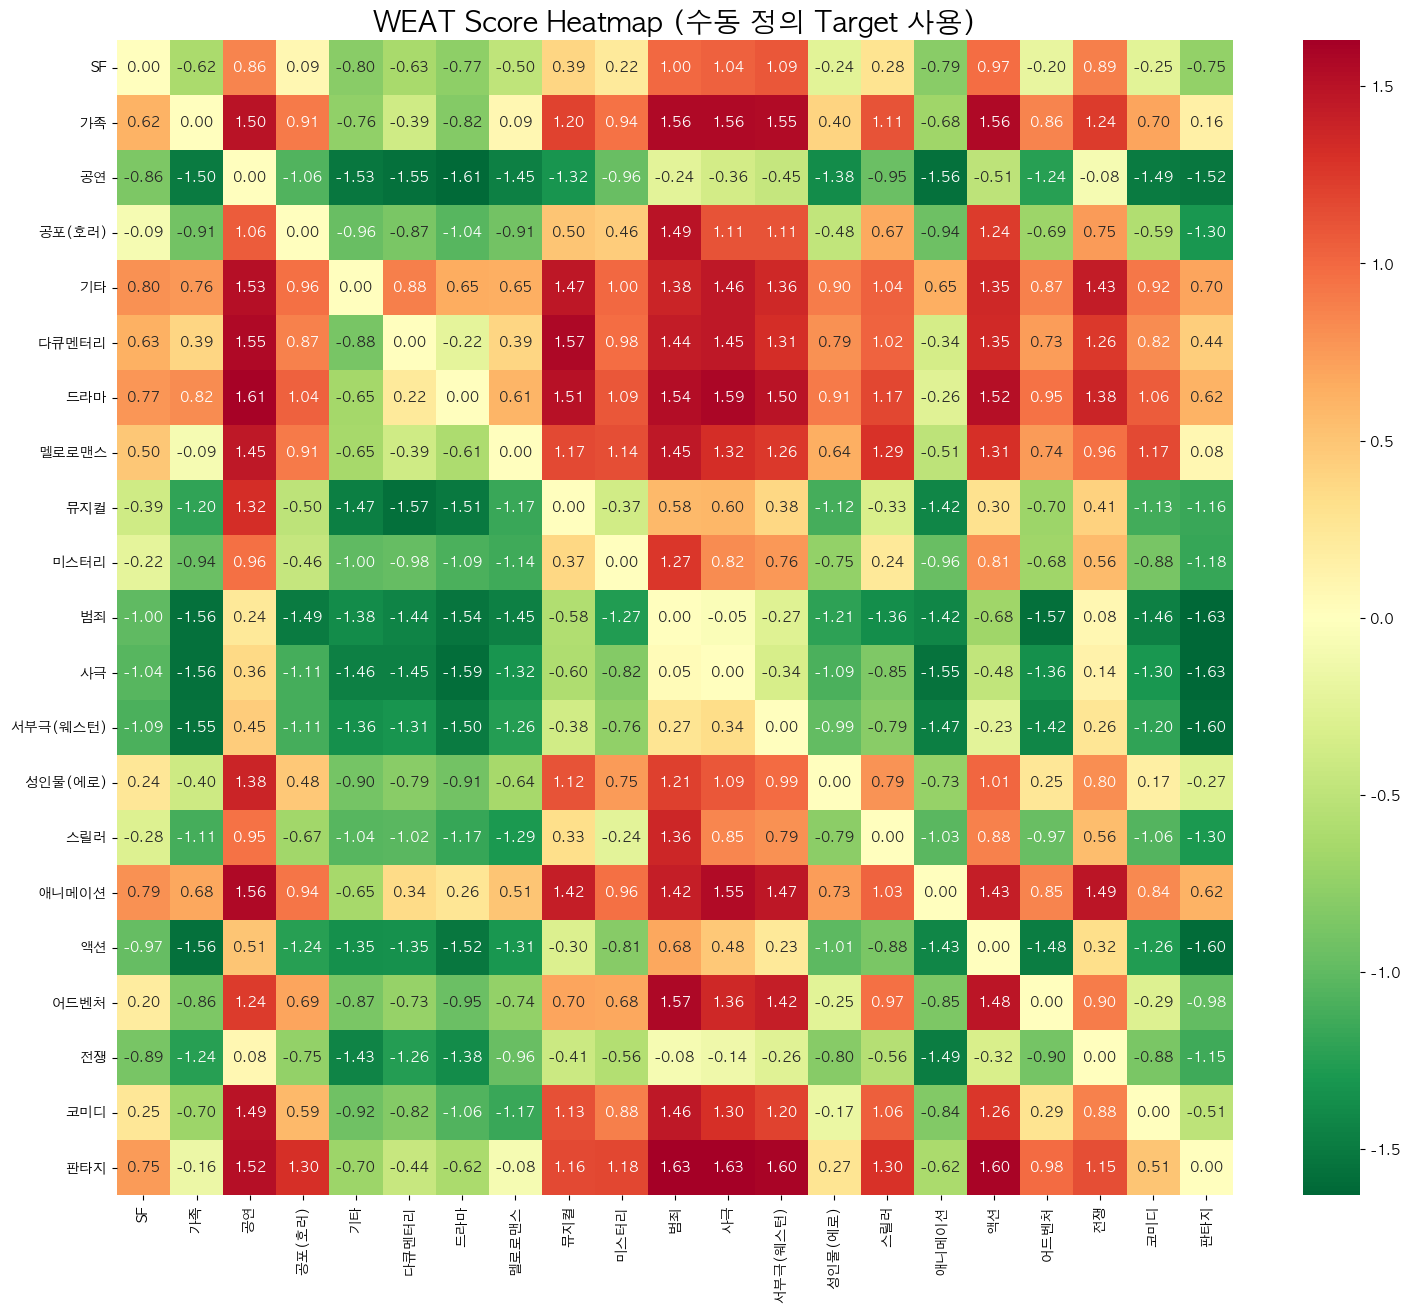

In [13]:
# 수동으로 정의한 Target을 기준으로 히트맵 다시 그리기

# 1. 수동 정의 및 필터링 (이전 셀에서 실행했지만, 명확성을 위해 다시 포함)
manual_art_words = ['작품성', '미학', '철학', '독립', '예술', '감독주의', '미장센', '비평가', '상징']
manual_gen_words = ['블록버스터', '흥행', '상업', '대중', '오락', '슈퍼히어로', 'CG', '캐스팅', '개봉']

filtered_art_words = [word for word in manual_art_words if word in model.wv]
filtered_gen_words = [word for word in manual_gen_words if word in model.wv]

# 2. 새로운 Target 임베딩 준비
X_manual = np.array([model.wv[word] for word in filtered_art_words])
Y_manual = np.array([model.wv[word] for word in filtered_gen_words])

# 3. 새로운 WEAT 점수 매트릭스 계산
manual_matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

for i in range(len(genre_name)):
    for j in range(i + 1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])

        # 새로운 Target(X_manual, Y_manual)을 사용해 점수 계산
        score = weat_score(X_manual, Y_manual, A, B)
        manual_matrix[i][j] = score
        manual_matrix[j][i] = -score

# 4. 새로운 히트맵 시각화
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(manual_matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', fmt='.2f', ax=ax)
ax.set_title('WEAT Score Heatmap (수동 정의 Target 사용)', fontsize=20)
plt.show()